# Setup (local)

In [1]:
%ls

colab_RF_CIs_on_reproducing.ipynb
colab_extended_grid_search_pipeline.ipynb
colab_grid_search_pipeline.ipynb
colab_reproducing_grid_search_pipeline.ipynb
colab_reproducing_rf_ci.ipynb
necessary_eda.ipynb
visualise_extended_grid_search_results.ipynb
visualise_grid_search_results.ipynb
visualise_reproducing_grid_search_results.ipynb


In [2]:
%ls ../data/

ESOL_README
FreeSolv_README
Lipo_README
esol_original.csv
esol_original_1024ecfp4_features.csv
esol_original_1024ecfp6_features.csv
esol_original_2048ecfp4_features.csv
esol_original_2048ecfp6_features.csv
esol_original_IdSmilesLabels.csv
esol_original_extra_features.csv
esol_original_rdkit_features.csv
freesolv_original.csv
freesolv_original_1024ecfp4_features.csv
freesolv_original_1024ecfp6_features.csv
freesolv_original_2048ecfp4_features.csv
freesolv_original_2048ecfp6_features.csv
freesolv_original_IdSmilesLabels.csv
freesolv_original_rdkit_features.csv
lipophilicity_original.csv
lipophilicity_original_1024ecfp4_features.csv
lipophilicity_original_1024ecfp6_features.csv
lipophilicity_original_2048ecfp4_features.csv
lipophilicity_original_2048ecfp6_features.csv
lipophilicity_original_IdSmilesLabels.csv
lipophilicity_original_rdkit_features.csv


## Import modules

In [3]:
import warnings
warnings.filterwarnings('ignore')

# saving models
import json
import pickle

# directory
import os
import sys

# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

# # metrics
from scipy.stats import pearsonr
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import jaccard_score # Tanimoto

# # making custom metrics
# from sklearn.metrics import make_scorer

# # model selection
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

# # preprocessing
from sklearn.feature_selection import VarianceThreshold # to remove zero-var features
# # from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

# # models
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import ElasticNetCV, ElasticNet
# from sklearn.ensemble import RandomForestRegressor

# from xgboost import XGBRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import GradientBoostingRegressor

# from sklearn.neural_network import MLPRegressor

# from sklearn.kernel_ridge import KernelRidge

# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel
# from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct

# # pipelines
# # https://scikit-learn.org/stable/modules/compose.html#combining-estimators
# from sklearn.pipeline import make_pipeline, Pipeline

## Set plotting style

In [4]:
%matplotlib inline
# plt.style.use('fivethirtyeight')

# plt.rcParams['axes.facecolor']='w'
# #plt.rcParams['axes.linewidth']=1
# plt.rcParams['axes.edgecolor']='w'
# plt.rcParams['figure.facecolor']='w'
# plt.rcParams['savefig.facecolor']='w'
# #plt.rcParams['grid.color']='white'

# Load Data (same everywhere)

## CHOOSE: dataset, smile_type

In [5]:
dataset = 'lipophilicity'
smile_type = 'original'

# READONLY

# small to large datasets
assert dataset in ['freesolv', 'esol', 'lipophilicity']
assert smile_type in ['original', 'protonated']

## Load Features and Targets

Leave all features here so setup and Load and prepare data are the same everywhere.

In [6]:
# original data
id_smile_target = pd.read_csv(f'../data/{dataset}_{smile_type}_IdSmilesLabels.csv', index_col=0)

# features
rdkit_features = pd.read_csv(f'../data/{dataset}_{smile_type}_rdkit_features.csv', index_col=0)

ecfp4_1024_features = pd.read_csv(f'../data/{dataset}_{smile_type}_1024ecfp4_features.csv', index_col=0)
ecfp6_1024_features = pd.read_csv(f'../data/{dataset}_{smile_type}_1024ecfp6_features.csv', index_col=0)

ecfp4_2048_features = pd.read_csv(f'../data/{dataset}_{smile_type}_2048ecfp4_features.csv', index_col=0)
ecfp6_2048_features = pd.read_csv(f'../data/{dataset}_{smile_type}_2048ecfp6_features.csv', index_col=0)

# load target
labels = id_smile_target['labels']

In [7]:
print('rdkit_features.shape:      ', rdkit_features.shape)
print('ecfp4_1024_features.shape: ', ecfp4_1024_features.shape)
print('ecfp6_1024_features.shape: ', ecfp6_1024_features.shape)
print('ecfp4_2048_features.shape: ', ecfp4_2048_features.shape)
print('ecfp6_2048_features.shape: ', ecfp6_2048_features.shape)
print('labels.shape:              ', labels.shape)

rdkit_features.shape:       (4200, 200)
ecfp4_1024_features.shape:  (4200, 1024)
ecfp6_1024_features.shape:  (4200, 1024)
ecfp4_2048_features.shape:  (4200, 2048)
ecfp6_2048_features.shape:  (4200, 2048)
labels.shape:               (4200,)


In [8]:
labels.head()

id
CHEMBL596271     3.54
CHEMBL1951080   -1.18
CHEMBL1771       3.69
CHEMBL234951     3.37
CHEMBL565079     3.10
Name: labels, dtype: float64

## Create one DataFrame with all features

In [9]:
all_features = pd.concat([rdkit_features,
                          ecfp4_1024_features, ecfp6_1024_features,
                          ecfp4_2048_features, ecfp6_2048_features],
                         axis='columns')

In [10]:
all_features.shape

(4200, 6344)

In [11]:
all_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,2048ecfp6-2038,2048ecfp6-2039,2048ecfp6-2040,2048ecfp6-2041,2048ecfp6-2042,2048ecfp6-2043,2048ecfp6-2044,2048ecfp6-2045,2048ecfp6-2046,2048ecfp6-2047
CHEMBL596271,8.838871,-4.082382,8.838871,0.008322,0.728444,340.858,319.690,340.145474,124.0,0.0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1951080,15.117958,-6.843264,15.117958,0.920611,0.545587,494.591,468.383,494.118143,178.0,0.0,...,0,0,0,0,0,0,0,1,0,0
CHEMBL1771,13.321227,-3.906276,13.321227,0.250582,0.807761,321.829,305.701,321.059027,110.0,0.0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL234951,14.213604,-4.272077,14.213604,0.187400,0.506650,419.890,401.746,419.070655,146.0,0.0,...,1,0,0,0,0,0,0,0,0,0
CHEMBL565079,14.167882,-4.810274,14.167882,0.671279,0.747686,381.480,354.264,381.216475,148.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Create feature_sets dictionary with pd.Index (containing feature names) as its elements

In [12]:
feature_sets = {
    'RDKit': rdkit_features.columns,
    '1024ecfp-4': ecfp4_1024_features.columns,
    '1024ecfp-6': ecfp6_1024_features.columns,
    '2048ecfp-4': ecfp4_2048_features.columns,
    '2048ecfp-6': ecfp6_2048_features.columns,
}

# Check for missing values, NaNs, Infs

In [13]:
cols_with_nas = set()
pos_with_nas = []

for name in rdkit_features.columns:
    if rdkit_features[name].isna().sum() > 0:
        print(name, 'na', rdkit_features[name].isna().sum())
        cols_with_nas.add(name)
        
        for obs in rdkit_features.index:
            if np.isnan(rdkit_features.loc[obs, name]):
                pos_with_nas.append((obs, name))
        
print(cols_with_nas)

MaxPartialCharge na 1
MinPartialCharge na 1
MaxAbsPartialCharge na 1
MinAbsPartialCharge na 1
{'MaxPartialCharge', 'MinPartialCharge', 'MinAbsPartialCharge', 'MaxAbsPartialCharge'}


In [14]:
for pos in pos_with_nas:
    print(pos)

('CHEMBL51085', 'MaxPartialCharge')
('CHEMBL51085', 'MinPartialCharge')
('CHEMBL51085', 'MaxAbsPartialCharge')
('CHEMBL51085', 'MinAbsPartialCharge')


In [15]:
rdkit_features.isnull().sum().sum()

4

In [16]:
(rdkit_features.isnull() == rdkit_features.isna()).all().all()

True

# Get number of zero-variance columns in unsplit (train-val-test) datasets

In [17]:
transform = VarianceThreshold()

In [18]:
featuresets_to_reductions = {}

for f in feature_sets:
    
    df = all_features[feature_sets[f]]
    print(f'{f} feature set originally has {df.shape[1]} columns')
    new_df = transform.fit_transform(X=df)
    print(f'{f} feature set without zero-var columns has {new_df.shape[1]} columns')
    print(f'Reduction: {df.shape[1] - new_df.shape[1]}\n')
    
    featuresets_to_reductions[f] = {
        'Original features': df.shape[1],
        'Reduced features': new_df.shape[1],
        'Reduction': df.shape[1] - new_df.shape[1]
    }
    
featuresets_to_reductions_df = pd.DataFrame(featuresets_to_reductions).T
display(featuresets_to_reductions_df)

RDKit feature set originally has 200 columns
RDKit feature set without zero-var columns has 188 columns
Reduction: 12

1024ecfp-4 feature set originally has 1024 columns
1024ecfp-4 feature set without zero-var columns has 1024 columns
Reduction: 0

1024ecfp-6 feature set originally has 1024 columns
1024ecfp-6 feature set without zero-var columns has 1024 columns
Reduction: 0

2048ecfp-4 feature set originally has 2048 columns
2048ecfp-4 feature set without zero-var columns has 2047 columns
Reduction: 1

2048ecfp-6 feature set originally has 2048 columns
2048ecfp-6 feature set without zero-var columns has 2048 columns
Reduction: 0



,Original features,Reduced features,Reduction
RDKit,200,188,12
1024ecfp-4,1024,1024,0
1024ecfp-6,1024,1024,0
2048ecfp-4,2048,2047,1
2048ecfp-6,2048,2048,0


In [19]:
featuresets_to_reductions_df.to_csv(f'../tables/{dataset}_{smile_type}_featuresets_to_zero_varaince_reductions.csv')

In [20]:
pd.read_csv(f'../tables/{dataset}_{smile_type}_featuresets_to_zero_varaince_reductions.csv', index_col=0)

,Original features,Reduced features,Reduction
RDKit,200,188,12
1024ecfp-4,1024,1024,0
1024ecfp-6,1024,1024,0
2048ecfp-4,2048,2047,1
2048ecfp-6,2048,2048,0


## Visuzlizing reductions

In [21]:
if np.array([f'{dataset}_original_featuresets_to_zero_varaince_reductions.csv' in os.listdir('../tables') for dataset in ['freesolv', 'esol', 'lipophilicity']]).all():
    esol_reductions = pd.read_csv(f'../tables/esol_original_featuresets_to_zero_varaince_reductions.csv', index_col=0)
    freesolv_reductions = pd.read_csv(f'../tables/freesolv_original_featuresets_to_zero_varaince_reductions.csv', index_col=0)
    lipophilicity_reductions = pd.read_csv(f'../tables/lipophilicity_original_featuresets_to_zero_varaince_reductions.csv', index_col=0)

In [22]:
# 642 rows
display(freesolv_reductions)

,Original features,Reduced features,Reduction
RDKit,200,167,33
1024ecfp-4,1024,849,175
1024ecfp-6,1024,981,43
2048ecfp-4,2048,1224,824
2048ecfp-6,2048,1617,431


In [23]:
# 1128 rows
display(esol_reductions)

,Original features,Reduced features,Reduction
RDKit,200,180,20
1024ecfp-4,1024,1013,11
1024ecfp-6,1024,1024,0
2048ecfp-4,2048,1856,192
2048ecfp-6,2048,2030,18


In [24]:
# 4200 rows
display(lipophilicity_reductions)

,Original features,Reduced features,Reduction
RDKit,200,188,12
1024ecfp-4,1024,1024,0
1024ecfp-6,1024,1024,0
2048ecfp-4,2048,2047,1
2048ecfp-6,2048,2048,0


In [25]:
list(feature_sets.keys())

['RDKit', '1024ecfp-4', '1024ecfp-6', '2048ecfp-4', '2048ecfp-6']

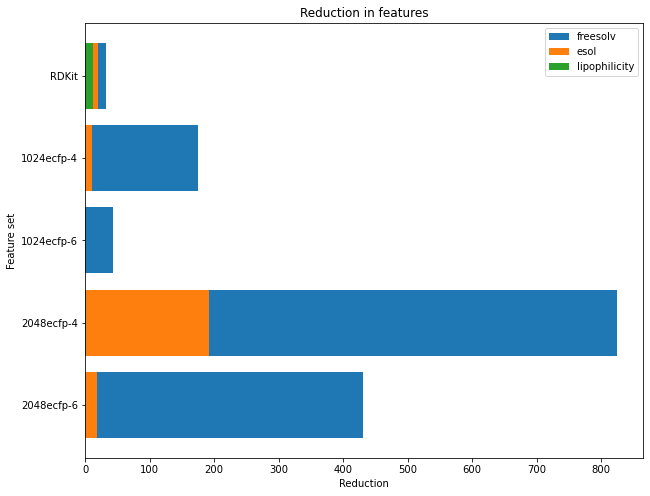

In [26]:
feature_sets_keys = ['RDKit', '1024ecfp-4', '1024ecfp-6', '2048ecfp-4', '2048ecfp-6'][::-1]
positions = range(len(feature_sets_keys))

plt.figure(figsize=(10, 8))
plt.tight_layout()

width = 0.8 # the width of the bars

f = plt.barh(positions, freesolv_reductions['Reduction'][::-1], width)
e = plt.barh(positions, esol_reductions['Reduction'][::-1], width)
l = plt.barh(positions, lipophilicity_reductions['Reduction'][::-1], width)

plt.yticks(positions, feature_sets_keys)
plt.ylabel('Feature set')
plt.xlabel('Reduction')
plt.title('Reduction in features')

plt.legend((f[0], e[0], l[0]), ('freesolv', 'esol', 'lipophilicity'))

# TODO: fix y-labels to fit the saved image
plt.savefig('../figures/comparison_of_zero_var_feature_reduction_for_all_datasets.png')
plt.show()

# Check RDKit descriptors for highly correlated features with the targets

## logP columns (a lead from Garrett)

In [27]:
import re

suspicious_cols = []
for name in rdkit_features.columns:
    m = re.match('(.)*(logP|LogP)(.)*', name)
    if m is not None:
        suspicious_cols.append(m[0])

In [28]:
suspicious_cols

['SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_VSA5',
 'SlogP_VSA6',
 'SlogP_VSA7',
 'SlogP_VSA8',
 'SlogP_VSA9',
 'MolLogP']

## Iteration through all and checking correlations

In [29]:
threshold = 0.75
cols_to_remove = [] # column names with correlation > threshold
col_name_1 = 'pearson_r'
col_name_2 = 'abs(pearson_r)'
all_correlations = {
    col_name_1: {},
    col_name_2: {}
}

for name in rdkit_features.columns.difference(cols_with_nas):
    all_correlations[col_name_1][name] = pearsonr(rdkit_features[name], labels)[0]
    all_correlations[col_name_2][name] = np.abs(pearsonr(rdkit_features[name], labels)[0])
    if np.abs(all_correlations[col_name_2][name]) > threshold:
        cols_to_remove.append(name)

print(len(all_correlations[col_name_2]))
cols_to_remove

196


[]

In [30]:
all_correlations_df = pd.DataFrame(all_correlations).sort_values(by=col_name_2, ascending=False)

print(dataset)
display(all_correlations_df[:10])

lipophilicity


,pearson_r,abs(pearson_r)
MolLogP,0.415450,0.415450
fr_COO,-0.353581,0.353581
fr_COO2,-0.353581,0.353581
BalabanJ,-0.301965,0.301965
NumAromaticRings,0.297561,0.297561
fr_Al_COO,-0.282441,0.282441
RingCount,0.280276,0.280276
FpDensityMorgan1,-0.274716,0.274716
SlogP_VSA6,0.236984,0.236984
SMR_VSA7,0.226008,0.226008


In [31]:
print(dataset)
all_correlations_df.loc[suspicious_cols].sort_values(by=col_name_2, ascending=False)

lipophilicity


,pearson_r,abs(pearson_r)
MolLogP,0.415450,0.415450
SlogP_VSA6,0.236984,0.236984
SlogP_VSA10,0.185836,0.185836
SlogP_VSA8,0.139798,0.139798
SlogP_VSA5,0.074747,0.074747
SlogP_VSA12,0.059787,0.059787
SlogP_VSA3,-0.059643,0.059643
SlogP_VSA4,0.054993,0.054993
SlogP_VSA1,-0.040483,0.040483
SlogP_VSA7,-0.022857,0.022857


In [32]:
print(dataset)
display(all_correlations_df[-10:])

lipophilicity


,pearson_r,abs(pearson_r)
SlogP_VSA9,NaN,NaN
fr_azide,NaN,NaN
fr_diazo,NaN,NaN
fr_isocyan,NaN,NaN
fr_isothiocyan,NaN,NaN
fr_nitro_arom_nonortho,NaN,NaN
fr_nitroso,NaN,NaN
fr_prisulfonamd,NaN,NaN
fr_thiocyan,NaN,NaN
fr_unbrch_alkane,NaN,NaN


How many NaNs did we get?

In [33]:
all_correlations_df[col_name_1].isna().sum()

12

Why do we get NaNs?

In [34]:
all_correlations_df.iloc[-1,:]

pearson_r        NaN
abs(pearson_r)   NaN
Name: fr_unbrch_alkane, dtype: float64

In [35]:
all_correlations_df.iloc[-1,:].name

'fr_unbrch_alkane'

In [36]:
rdkit_features[all_correlations_df.iloc[-1,:].name]

CHEMBL596271     0.0
CHEMBL1951080    0.0
CHEMBL1771       0.0
CHEMBL234951     0.0
CHEMBL565079     0.0
                ... 
CHEMBL496929     0.0
CHEMBL199147     0.0
CHEMBL15932      0.0
CHEMBL558748     0.0
CHEMBL237889     0.0
Name: fr_unbrch_alkane, Length: 4200, dtype: float64

In [37]:
rdkit_features[all_correlations_df.iloc[-1,:].name].std()

0.0

**Important:** we were getting NaNs for correlations for features with zero variance.

Let's check:

**Zero-variance features:**

In [38]:
zero_var_features = rdkit_features.columns[rdkit_features.std(axis=0) == 0]
zero_var_features

Index(['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_azide', 'fr_diazo',
       'fr_isocyan', 'fr_isothiocyan', 'fr_nitro_arom_nonortho', 'fr_nitroso',
       'fr_prisulfonamd', 'fr_thiocyan', 'fr_unbrch_alkane'],
      dtype='object')

**Features with NaNs:**

In [39]:
nan_corr_features = all_correlations_df.index[all_correlations_df[col_name_1].isna()]
nan_corr_features

Index(['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_azide', 'fr_diazo',
       'fr_isocyan', 'fr_isothiocyan', 'fr_nitro_arom_nonortho', 'fr_nitroso',
       'fr_prisulfonamd', 'fr_thiocyan', 'fr_unbrch_alkane'],
      dtype='object')

**Check if the same:**

In [40]:
(zero_var_features == nan_corr_features).all()

True

# Automate the process of removing high correlation features

In [41]:
def list_highly_correlated(df_features, targets, threshold=0.8):
    """
    List column names of the dataframe of features which are highly correlated
    to the target (absolute value of the correlation is greater than the threshold).

    Parameters
    ----------
    df_features : (n, p) pandas.core.frame.DataFrame of p features
                  Input array.
    targets     : (n,) pandas.core.series.Series of targets
                  Input array.
    threshold   : float in [0, 1] above which we consider a feature highly correlated

    Returns
    -------
    cols_to_remove : list of column names from df_features, which are highly correlated
                     to the target

    """
    # check bounds for abs(correlation) threshold
    assert 0 <= threshold <= 1

    # df_features and targets should have the same length
    assert df_features.shape[0] == targets.shape[0]
    #print('Original shapes:                 ', df_features.shape, targets.shape)

    # remove na rows
    X = df_features.dropna(axis=0)
    y = targets[X.index]
    #print('Removed NA rows, shapes:         ', X.shape, y.shape)

    # remove zero-variace columns
    zero_std = X.std() < 1e-5
    zero_std_cols = X.columns[zero_std]
    X = X.drop(zero_std_cols, axis=1)
    #print('Removed zero-var columns, shapes:', X.shape, y.shape)

    # record highly correlated features
    cols_to_remove = []
    for name in X.columns:
        # print(name, np.abs(pearsonr(X[name], y)[0]))
        if np.abs(pearsonr(X[name], y)[0]) > threshold:
            cols_to_remove.append(name)

    print(f'\nFound {len(cols_to_remove)} highly-correlated feature(s):')
    print(cols_to_remove)
    return cols_to_remove

In [42]:
list_highly_correlated(rdkit_features, labels, threshold=0.8)


Found 0 highly-correlated feature(s):
[]


[]